# Pourquoi et comment

**Objectif** : recueillir les pnn (càd les identifiants IdRef) des contributeurs à la revue.

**Démarche** : 
1) Avec des auteurs du BSPE : faire une estimation du nombre de noms qui manquent. 
2) 
3) 

**Documentation**: Recours à l'API SolR<a href = "http://documentation.abes.fr/aideidrefdeveloppeur/index.html"> abes </a> 


In [1]:
import re
import pandas as pd
import csv
import numpy as np 
import requests
from bs4 import BeautifulSoup
import lxml

## 1. Structurer la liste des nom/prénoms

In [2]:
with open ("../BSPE/Membres_SPE/Liste-Noms-Contributeurs.csv") as contributeurs:
    df_contributeurs = pd.read_csv(contributeurs)

In [3]:
df_contributeurs

,NOM (Prenom)
0,ACHALME (P.)
1,ADDE (R.)
2,AHMED (E.)
3,ALARY (A.)
4,ALLAIN (Jacques)
...,...
658,YVERNAULT (A.)
659,YVON (P.)
660,ZABOLOTNY
661,ZAMMIT (TH.)


In [4]:
## Séparer NOM et Prénom : 

#Nouvelle colonne pour le NOM => .iloc[i,1]
df_contributeurs["NOM"] = df_contributeurs.apply(lambda _: '', axis=1)
#Nouvelle colonne pour le PRENOM => .iloc[i,2]
df_contributeurs["Prenom"] = df_contributeurs.apply(lambda _: '', axis=1)


#Regex NOM (Prénom)
reNom = r'([-\'A-zÀ-ÿ]+((-| )[-\'A-zÀ-ÿ]+)?)( \(.*)?'
rePrenom = r'\(([-\'A-zÀ-ÿ]+(\.)?){1,2}\)'

for i in range(len(df_contributeurs)):
    
    df_contributeurs.iloc[i,1] = re.search(reNom,df_contributeurs.iloc[i,0]).group(1)
    Prenom = re.search(rePrenom,df_contributeurs.iloc[i,0])
    if Prenom:
        Prenom2=re.sub(r' {1,2}',"",Prenom.group(1))
        df_contributeurs.iloc[i,2]=Prenom2
   

In [5]:
df_contributeurs

,NOM (Prenom),NOM,Prenom
0,ACHALME (P.),ACHALME,P.
1,ADDE (R.),ADDE,R.
2,AHMED (E.),AHMED,E.
3,ALARY (A.),ALARY,A.
4,ALLAIN (Jacques),ALLAIN,Jacques
...,...,...,...
658,YVERNAULT (A.),YVERNAULT,A.
659,YVON (P.),YVON,P.
660,ZABOLOTNY,ZABOLOTNY,
661,ZAMMIT (TH.),ZAMMIT,TH.


## 2. Générer les url idref et le entrer dans le df

In [6]:
#Ajout de colonnes au df pour les url. 
df_contributeurs = df_contributeurs.reindex(columns = df_contributeurs.columns.tolist() + ['Recherche_G','Recherche_NomPrenom'])
RechercheG = []
RechercheNOMPrenom =[]

In [7]:
for i in range(len(df_contributeurs)):
#     print(df_contributeurs.iloc[i,0])
    NOM=df_contributeurs.iloc[i,1]
    Prenom=df_contributeurs.iloc[i,2]
    
    #Paramétrage : 
    ## => recordtype_z :h (càd Auteur Titre)
    
    #url générale:
    df_contributeurs.iloc[i,3]="https://www.idref.fr/Sru/Solr?q=persname_t:"+NOM+"%20"+Prenom+"&sort=score%20desc&version=2.2&start=0&rows=30&indent=on&fl=id,ppn_z,recordtype_z:h,affcourt_z"
    RechercheG.append(df_contributeurs.iloc[i,3])
    
    #url NOM Prenom : 
    df_contributeurs.iloc[i,4] ="https://www.idref.fr/Sru/Solr?q=persname_t:("+NOM+"%20AND%20"+Prenom+")&sort=score%20desc&version=2.2&start=0&rows=30&indent=on&fl=id,ppn_z,recordtype_z:h,affcourt_z"
    RechercheNOMPrenom.append(df_contributeurs.iloc[i,4])


In [8]:
df_contributeurs

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom
0,ACHALME (P.),ACHALME,P.,https://www.idref.fr/Sru/Solr?q=persname_t:ACH...,https://www.idref.fr/Sru/Solr?q=persname_t:(AC...
1,ADDE (R.),ADDE,R.,https://www.idref.fr/Sru/Solr?q=persname_t:ADD...,https://www.idref.fr/Sru/Solr?q=persname_t:(AD...
2,AHMED (E.),AHMED,E.,https://www.idref.fr/Sru/Solr?q=persname_t:AHM...,https://www.idref.fr/Sru/Solr?q=persname_t:(AH...
3,ALARY (A.),ALARY,A.,https://www.idref.fr/Sru/Solr?q=persname_t:ALA...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...
4,ALLAIN (Jacques),ALLAIN,Jacques,https://www.idref.fr/Sru/Solr?q=persname_t:ALL...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...
...,...,...,...,...,...
658,YVERNAULT (A.),YVERNAULT,A.,https://www.idref.fr/Sru/Solr?q=persname_t:YVE...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...
659,YVON (P.),YVON,P.,https://www.idref.fr/Sru/Solr?q=persname_t:YVO...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...
660,ZABOLOTNY,ZABOLOTNY,,https://www.idref.fr/Sru/Solr?q=persname_t:ZAB...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...
661,ZAMMIT (TH.),ZAMMIT,TH.,https://www.idref.fr/Sru/Solr?q=persname_t:ZAM...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...


## 3. Chercher s'il existe au moins une notice associée à l'url idref

Méthode : pour chaque url chercher la valeur de l'attribut numFound dans l'elt <result>
\    
`<result name="response" numFound="0" start="0"/>`

In [9]:
df_contributeurs = df_contributeurs.reindex(columns = df_contributeurs.columns.tolist() + ['Recherche_G-nbr','Recherche_NomPrenom-nbr'])    

In [10]:
df_contributeurs

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_G-nbr,Recherche_NomPrenom-nbr
0,ACHALME (P.),ACHALME,P.,https://www.idref.fr/Sru/Solr?q=persname_t:ACH...,https://www.idref.fr/Sru/Solr?q=persname_t:(AC...,NaN,NaN
1,ADDE (R.),ADDE,R.,https://www.idref.fr/Sru/Solr?q=persname_t:ADD...,https://www.idref.fr/Sru/Solr?q=persname_t:(AD...,NaN,NaN
2,AHMED (E.),AHMED,E.,https://www.idref.fr/Sru/Solr?q=persname_t:AHM...,https://www.idref.fr/Sru/Solr?q=persname_t:(AH...,NaN,NaN
3,ALARY (A.),ALARY,A.,https://www.idref.fr/Sru/Solr?q=persname_t:ALA...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...,NaN,NaN
4,ALLAIN (Jacques),ALLAIN,Jacques,https://www.idref.fr/Sru/Solr?q=persname_t:ALL...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...,NaN,NaN
...,...,...,...,...,...,...,...
658,YVERNAULT (A.),YVERNAULT,A.,https://www.idref.fr/Sru/Solr?q=persname_t:YVE...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...,NaN,NaN
659,YVON (P.),YVON,P.,https://www.idref.fr/Sru/Solr?q=persname_t:YVO...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...,NaN,NaN
660,ZABOLOTNY,ZABOLOTNY,,https://www.idref.fr/Sru/Solr?q=persname_t:ZAB...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...,NaN,NaN
661,ZAMMIT (TH.),ZAMMIT,TH.,https://www.idref.fr/Sru/Solr?q=persname_t:ZAM...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...,NaN,NaN


In [11]:
def IdRef_numfound_auteur (col):
    list_numfound_IdRef = []

    for url in col:
        r = requests.get(url)
        xml = r.text
        #print(r.text)

        soup = BeautifulSoup(xml,'lxml')
        eltResult = soup.find_all('result')

        for att in eltResult:
            attnumFound = att.get("numfound")

        list_numfound_IdRef.append(attnumFound)
    
    return list_numfound_IdRef

#<result name="response" numFound="0" start="0"/>

In [12]:
col = df_contributeurs["Recherche_G"]
df_contributeurs["Recherche_G-nbr"] = IdRef_numfound_auteur(col)

In [13]:
df_contributeurs

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_G-nbr,Recherche_NomPrenom-nbr
0,ACHALME (P.),ACHALME,P.,https://www.idref.fr/Sru/Solr?q=persname_t:ACH...,https://www.idref.fr/Sru/Solr?q=persname_t:(AC...,4,NaN
1,ADDE (R.),ADDE,R.,https://www.idref.fr/Sru/Solr?q=persname_t:ADD...,https://www.idref.fr/Sru/Solr?q=persname_t:(AD...,27,NaN
2,AHMED (E.),AHMED,E.,https://www.idref.fr/Sru/Solr?q=persname_t:AHM...,https://www.idref.fr/Sru/Solr?q=persname_t:(AH...,3625,NaN
3,ALARY (A.),ALARY,A.,https://www.idref.fr/Sru/Solr?q=persname_t:ALA...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...,77,NaN
4,ALLAIN (Jacques),ALLAIN,Jacques,https://www.idref.fr/Sru/Solr?q=persname_t:ALL...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...,364,NaN
...,...,...,...,...,...,...,...
658,YVERNAULT (A.),YVERNAULT,A.,https://www.idref.fr/Sru/Solr?q=persname_t:YVE...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...,16,NaN
659,YVON (P.),YVON,P.,https://www.idref.fr/Sru/Solr?q=persname_t:YVO...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...,853,NaN
660,ZABOLOTNY,ZABOLOTNY,,https://www.idref.fr/Sru/Solr?q=persname_t:ZAB...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...,2,NaN
661,ZAMMIT (TH.),ZAMMIT,TH.,https://www.idref.fr/Sru/Solr?q=persname_t:ZAM...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...,33,NaN


In [14]:
df_contributeurs.iloc[2,4]

'https://www.idref.fr/Sru/Solr?q=persname_t:(AHMED%20AND%20E.)&sort=score%20desc&version=2.2&start=0&rows=30&indent=on&fl=id,ppn_z,recordtype_z:h,affcourt_z'

In [15]:
col = df_contributeurs["Recherche_NomPrenom"]
df_contributeurs["Recherche_NomPrenom-nbr"] = IdRef_numfound_auteur(col)

In [16]:
df_contributeurs

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_G-nbr,Recherche_NomPrenom-nbr
0,ACHALME (P.),ACHALME,P.,https://www.idref.fr/Sru/Solr?q=persname_t:ACH...,https://www.idref.fr/Sru/Solr?q=persname_t:(AC...,4,0
1,ADDE (R.),ADDE,R.,https://www.idref.fr/Sru/Solr?q=persname_t:ADD...,https://www.idref.fr/Sru/Solr?q=persname_t:(AD...,27,0
2,AHMED (E.),AHMED,E.,https://www.idref.fr/Sru/Solr?q=persname_t:AHM...,https://www.idref.fr/Sru/Solr?q=persname_t:(AH...,3625,15
3,ALARY (A.),ALARY,A.,https://www.idref.fr/Sru/Solr?q=persname_t:ALA...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...,77,0
4,ALLAIN (Jacques),ALLAIN,Jacques,https://www.idref.fr/Sru/Solr?q=persname_t:ALL...,https://www.idref.fr/Sru/Solr?q=persname_t:(AL...,364,5
...,...,...,...,...,...,...,...
658,YVERNAULT (A.),YVERNAULT,A.,https://www.idref.fr/Sru/Solr?q=persname_t:YVE...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...,16,0
659,YVON (P.),YVON,P.,https://www.idref.fr/Sru/Solr?q=persname_t:YVO...,https://www.idref.fr/Sru/Solr?q=persname_t:(YV...,853,4
660,ZABOLOTNY,ZABOLOTNY,,https://www.idref.fr/Sru/Solr?q=persname_t:ZAB...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...,2,4
661,ZAMMIT (TH.),ZAMMIT,TH.,https://www.idref.fr/Sru/Solr?q=persname_t:ZAM...,https://www.idref.fr/Sru/Solr?q=persname_t:(ZA...,33,0


In [17]:
df_contributeurs.to_csv("IdRef_BSPE.tsv", sep="\t")

## Exploration des résultats

### A) Pour l'url "générale" 

In [18]:
#Le maximum d'occurences d'un même nom est de 99.061
#On  535 noms de personnes qui n'apparaissent pas dans IdRef

print(df_contributeurs["Recherche_G-nbr"].max())
df_G=df_contributeurs.groupby(by="Recherche_G-nbr").count()

99062


In [19]:
df_G.sort_values(by="NOM")

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_NomPrenom-nbr
Recherche_G-nbr,,,,,,
79,1,1,1,1,1,1
257,1,1,1,1,1,1
2701,1,1,1,1,1,1
272,1,1,1,1,1,1
275,1,1,1,1,1,1
...,...,...,...,...,...,...
4,19,19,19,19,19,19
3,20,20,20,20,20,20
1,24,24,24,24,24,24


In [26]:
df_G.describe()

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_NomPrenom-nbr
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,2.641434,2.641434,2.641434,2.641434,2.641434,2.641434
std,4.897236,4.897236,4.897236,4.897236,4.897236,4.897236
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000


In [47]:
df_contributeurs.loc[df_contributeurs["Recherche_G-nbr"] == "0"]

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_G-nbr,Recherche_NomPrenom-nbr
5,ANDREANI-CONSTANTINI (MME),ANDREANI-CONSTANTINI,MME,https://www.idref.fr/Sru/Solr?q=persname_t:AND...,https://www.idref.fr/Sru/Solr?q=persname_t:(AN...,0,0
8,ARAVANDINOS (A.),ARAVANDINOS,A.,https://www.idref.fr/Sru/Solr?q=persname_t:ARA...,https://www.idref.fr/Sru/Solr?q=persname_t:(AR...,0,0
38,BEKENSKY (P.W.),BEKENSKY,W.,https://www.idref.fr/Sru/Solr?q=persname_t:BEK...,https://www.idref.fr/Sru/Solr?q=persname_t:(BE...,0,0
39,BELITZER (A.W.),BELITZER,W.,https://www.idref.fr/Sru/Solr?q=persname_t:BEL...,https://www.idref.fr/Sru/Solr?q=persname_t:(BE...,0,0
64,BONNEFAY(),BONNEFAY,,https://www.idref.fr/Sru/Solr?q=persname_t:BON...,https://www.idref.fr/Sru/Solr?q=persname_t:(BO...,0,0
106,CAMBILLET,CAMBILLET,,https://www.idref.fr/Sru/Solr?q=persname_t:CAM...,https://www.idref.fr/Sru/Solr?q=persname_t:(CA...,0,2
107,CAMINOPETROS (JEAN),CAMINOPETROS,JEAN,https://www.idref.fr/Sru/Solr?q=persname_t:CAM...,https://www.idref.fr/Sru/Solr?q=persname_t:(CA...,0,0
145,COUENDI (M.),COUENDI,M.,https://www.idref.fr/Sru/Solr?q=persname_t:COU...,https://www.idref.fr/Sru/Solr?q=persname_t:(CO...,0,0
153,CROVERI (P.),CROVERI,P.,https://www.idref.fr/Sru/Solr?q=persname_t:CRO...,https://www.idref.fr/Sru/Solr?q=persname_t:(CR...,0,0
171,DEADERICK (W. H.),DEADERICK,,https://www.idref.fr/Sru/Solr?q=persname_t:DEA...,https://www.idref.fr/Sru/Solr?q=persname_t:(DE...,0,0


In [46]:
df_G_zero.size

392

<AxesSubplot:ylabel='Frequency'>

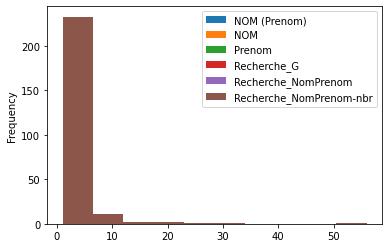

In [32]:
df_G.plot.hist()

### A) Pour l'url "générale" 

In [20]:
df_NomPrenom =df_contributeurs.groupby(by="Recherche_NomPrenom-nbr").count()

In [28]:
df_NomPrenom.sort_values(by="NOM")
df_NomPrenom.describe()

,NOM (Prenom),NOM,Prenom,Recherche_G,Recherche_NomPrenom,Recherche_G-nbr
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,14.733333,14.733333,14.733333,14.733333,14.733333,14.733333
std,57.096569,57.096569,57.096569,57.096569,57.096569,57.096569
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000


<AxesSubplot:ylabel='Frequency'>

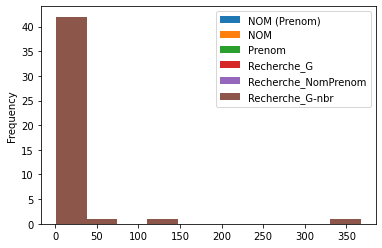

In [31]:
df_NomPrenom.plot.hist()